In [1]:
import numpy as np
from fnc.LMPC_CT import LMPC_CT
from fnc.MIX_OL_CL import MIX_OL_CL
import pdb
import dill
import matplotlib.pyplot as plt
from tempfile import TemporaryFile
import copy
import datetime
import os
import sys,os
sys.path.append(sys.path[0]+'/../../utils/')
from simulators import *


# Minimum LMPC with time varing safe set and $V$-function

The goal of this problem is to steer the unicycle model from a starting state to a goal set in minimum time. First, we compute a feasible trajectory used to initialize the LMPC.

In [2]:
# parameter initialization
radius = 10.0 

simulator = SIMULATOR("unicycle", radius = radius, dt = 0.5)

N = 4
road_half_width = 2.0
mix_ol_cl = MIX_OL_CL(radius)

# ====================================================================================
# Run simulation to compute feasible solution
# ====================================================================================
x0 = [0, 0, 0] # initial condition
xcl_feasible = [x0]
ucl_feasible =[]
xt           = x0
time         = 0

print("Start closed-loop simulation")
totTimeSteps = 101
for time in range(totTimeSteps-1):
    xt = xcl_feasible[time] # Read measurements

    mix_ol_cl.solve(xt, time, totTimeSteps) # Solve FTOCP

    # Read input and apply it to the system
    ut = mix_ol_cl.uPred
    ucl_feasible.append(ut)
    xcl_feasible.append(simulator.sim(xcl_feasible[time], ut))
    time += 1
print("Done closed-loop simulation")

Start closed-loop simulation
Done closed-loop simulation


**Plot first feasible trajectory**

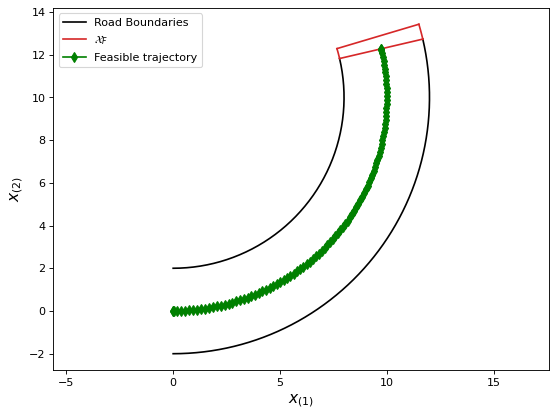

In [3]:
# Compute road edges and goal set in X-Y coordinates for plotting
s_start = 0
s_end = xcl_feasible[-1][0]
road_boundary_left = simulator.computeRoadEdges(s_start, s_end, radius, road_half_width, signEdge=-1, disc = 0.1) # np.array(pointCircleIn)
road_boundary_right = simulator.computeRoadEdges(s_start, s_end, radius, road_half_width, signEdge=1, disc = 0.1) # np.array(pointCircleOut)

s_finish_line_start = xcl_feasible[-1][0]
s_finish_line_end = s_finish_line_start + 0.5
goal_region_left = simulator.computeRoadEdges(s_finish_line_start, s_finish_line_end, radius, road_half_width, signEdge=-1, disc = 0.1) # np.array(pointCircleIn)
goal_region_right = simulator.computeRoadEdges(s_finish_line_start, s_finish_line_end, radius, road_half_width, signEdge=1, disc = 0.1) # np.array(pointCircleOut)

#Plot closed-loop trajectory
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(road_boundary_left[:,0], road_boundary_left[:,1], '-k', label='Road Boundaries')
plt.plot(road_boundary_right[:,0], road_boundary_right[:,1], '-k')

plt.plot(goal_region_left[:,0], goal_region_left[:,1], '-', color='C3', label='$\mathcal{X}_F$')
plt.plot(goal_region_right[:,0], goal_region_right[:,1], '-', color='C3')
plt.plot([goal_region_right[0,0], goal_region_left[0,0]], [goal_region_right[0,1], goal_region_left[0,1]], '-', color='C3')
plt.plot([goal_region_right[-1,0], goal_region_left[-1,0]], [goal_region_right[-1,1], goal_region_left[-1,1]], '-', color='C3')

# Convert from curvilinear to XY
xcl_feasible_xy = simulator.from_curvilinear_to_xy(xcl_feasible)
plt.plot(np.array(xcl_feasible_xy)[:,0], np.array(xcl_feasible_xy)[:,1], '-dg', label='Feasible trajectory')

plt.xlabel('$x_{(1)}$', fontsize=14)
plt.ylabel('$x_{(2)}$', fontsize=14)
plt.legend()
plt.axis('equal');

**Run LMPC for different parameters**

In the implementation below we used a subset of stated to design the LMPC. In particular, we have that:
- $P$ represents the number of states used to build the convex time varying safe set 
- $l$ represents the number of previous iterations used to construct the convex time varying safe set

In [4]:
P_list = [15, 20, 50, 200]
l_list = [1, 3, 4, 10]
itMax = 10 # Number or iteration to perform per LMPC settings

xcl_pl = []
for l,P in zip(l_list, P_list):
    print("Running LMPC for (l,P) = (", l,", ",P,")")
    # Initialize LMPC
    lmpc = LMPC_CT(N, simulator.dt, road_half_width,  l = l, P = P, verbose = False)
    
    # Construct terminal goal set
    Xf = np.array([[s_finish_line_start, -road_half_width, 0.0],[s_finish_line_end, road_half_width, 0.0]]).T
    lmpc.set_xf(Xf)
    Xf_vertices = np.concatenate((Xf,Xf), axis = 1 )
    Xf_vertices[1,2] = road_half_width
    Xf_vertices[1,3] = -road_half_width
    lmpc.Xf_vertices = Xf_vertices
    
    # Add feasible trajectory to the safe set
    lmpc.addTrajectory(xcl_feasible, ucl_feasible)

    itCounter = 0
    while itCounter < itMax: # Iteration loop
        time = 0
        xcl = [x0]
        ucl = []
        while (lmpc.checkTaskCompletion(xcl[-1]) == False): # Time loop
            # read measurement
            xt = xcl[time] 

            # Solve LMPC
            lmpc.solve(xt, verbose = 1) 

            # Apply input and store closed-loop data
            ut = lmpc.uPred[:,0]
            ucl.append(ut)
            xcl.append(simulator.sim(xcl[time], ut))

            # increment time counter
            time += 1

        # iteration completed. Add trajectory to the safe set
        lmpc.addTrajectory(xcl, ucl) 

        # Print and store results
        print("Completed Iteration: ", itCounter+1, ". Time to complete the task: ", len(xcl)-1)

        # Increment iteration counter
        itCounter += 1 
        
    xcl_pl.append(lmpc.SS)
    

Running LMPC for (l,P) = ( 1 ,  15 )

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



/opt/anaconda3/envs/py3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/anaconda3/envs/py3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Completed Iteration:  1 . Time to complete the task:  84
Completed Iteration:  2 . Time to complete the task:  69
Completed Iteration:  3 . Time to complete the task:  54
Completed Iteration:  4 . Time to complete the task:  40
Completed Iteration:  5 . Time to complete the task:  26
Completed Iteration:  6 . Time to complete the task:  17
Completed Iteration:  7 . Time to complete the task:  16
Completed Iteration:  8 . Time to complete the task:  16
Completed Iteration:  9 . Time to complete the task:  16
Completed Iteration:  10 . Time to complete the task:  16
Running LMPC for (l,P) = ( 3 ,  20 )
Completed Iteration:  1 . Time to complete the task:  79
Completed Iteration:  2 . Time to complete the task:  58
Completed Iteration:  3 . Time to complete the task:  37
Completed Iteration:  4 . Time to complete the task:  18
Completed Iteration:  5 . Time to complete the task:  16
Completed Iteration:  6 . Time to complete the task:  16
Completed Iteration:  7 . Time to complete the tas

**Plot results for different settings**

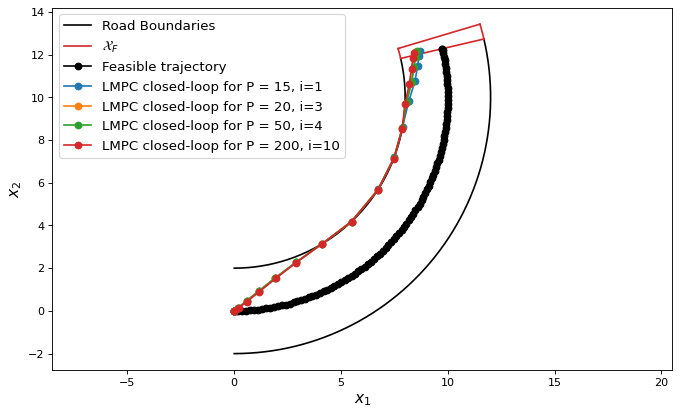

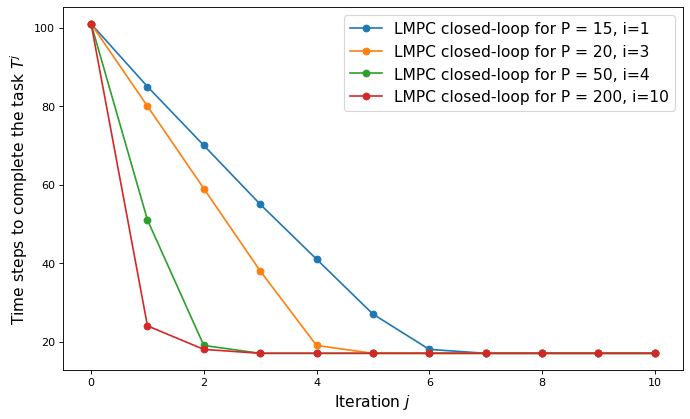

In [5]:
plt.figure(figsize=(10, 6), dpi=80)
# Plot road boundaries and goal set
plt.plot(road_boundary_left[:,0], road_boundary_left[:,1], '-k', label='Road Boundaries')
plt.plot(road_boundary_right[:,0], road_boundary_right[:,1], '-k')
plt.plot(goal_region_left[:,0], goal_region_left[:,1], '-', color='C3', label='$\mathcal{X}_F$')
plt.plot(goal_region_right[:,0], goal_region_right[:,1], '-', color='C3')
plt.plot([goal_region_right[0,0], goal_region_left[0,0]], [goal_region_right[0,1], goal_region_left[0,1]], '-', color='C3')
plt.plot([goal_region_right[-1,0], goal_region_left[-1,0]], [goal_region_right[-1,1], goal_region_left[-1,1]], '-', color='C3')

# Convert from curvilinear to XY
xcl_feasible_xy = simulator.from_curvilinear_to_xy(xcl_feasible)
plt.plot(np.array(xcl_feasible_xy)[:,0], np.array(xcl_feasible_xy)[:,1], '-ok', label='Feasible trajectory')

    
for i in range(len(xcl_pl)):
    xcl_xy = simulator.from_curvilinear_to_xy(xcl_pl[i][-1].T.tolist())
    plt.plot(np.array(xcl_xy)[:,0], np.array(xcl_xy)[:,1], '-o', label="LMPC closed-loop for P = "+str(P_list[i])+", i="+str(l_list[i]))


plt.xlabel('$x_{1}$', fontsize=14)
plt.ylabel('$x_{2}$', fontsize=14)
plt.legend(fontsize=12)
plt.axis('equal');
plt.savefig('NonlinearLMPC_Task.png')

plt.figure(figsize=(10, 6), dpi=80)
for i in range(len(xcl_pl)):
    task_completion = []
    for xcl_at_it in xcl_pl[i]:
        task_completion.append(xcl_at_it.shape[1])
    plt.plot(task_completion, '-o', label="LMPC closed-loop for P = "+str(P_list[i])+", i="+str(l_list[i]))
    
plt.legend(fontsize=14)
plt.xlabel('$\mathrm{Iteration~}j$', fontsize=14)
plt.ylabel('$\mathrm{Time~steps~to~complete~the~task~}T^j$', fontsize=14)
plt.savefig('NonlinearLMPC_Cost.png')

